

# False Clustering Rate Control in Mixture Models

https://arxiv.org/abs/2203.02597

13/03/2022

In this notebook, we demonstrate the use of our procedures. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
from sklearn.mixture import GaussianMixture

from mixture import sample_mixture
from procedure import baseline_procedure, plug_in_procedure, bootstrap_procedure
from misc import get_fcp

Model

In [2]:
n_samples = 100
n_classes = 2
mix_prop = np.array([1/n_classes for _ in range(n_classes)])


eps = 2
dimensionSize = 2
mean0 = np.zeros(dimensionSize)
mean1 = np.ones(dimensionSize) * eps / np.sqrt(dimensionSize)
means = np.array([mean0, mean1])
covariances = np.array([np.eye(dimensionSize) for _ in range(n_classes)])

Sample:

In [3]:
x,y = sample_mixture(n_samples, mix_prop, means, covariances)

Let us plot the data:

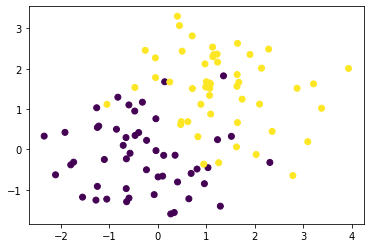

In [4]:
plt.scatter(x[:,0], x[:,1], c=y)
plt.show()

Next, fit a Gaussian mixture model: 

In [5]:
gmm = GaussianMixture(n_components=n_classes, max_iter = 100, n_init=100).fit(x)

ypred = gmm.predict(x)

The clustering is:

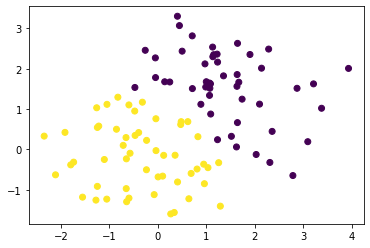

In [6]:
plt.scatter(x[:,0], x[:,1], c=ypred)
plt.show()

### Procedures for False Clustering Rate control

In [7]:
# nominal level
level=0.05

Oracle 

In [8]:
# computation of the true posterior group membership probabilities

joint_density = np.array([w*multivariate_normal.pdf(x,m,c) for w, m, c in zip(mix_prop, means, covariances)])
marg_density = np.sum(joint_density, axis=0)#marginal density for each X_i
post_probs = np.array([d/marg_density for d in joint_density]).T


# oracle procedure
selection = plug_in_procedure(post_probs, level)
ypred = np.argmax(post_probs, 1)

fcp_oracle, _, fsel_oracle = get_fcp(selection, y, ypred)

print("FCP", fcp_oracle)
print("Selection frequency", fsel_oracle)

FCP 0.03225806451612903
Selection frequency 0.62


For the empirical procedures, we need estimates of the parameters: 

In [9]:
weights_estimates = gmm.weights_
means_estimates = gmm.means_
covariances_estimates = gmm.covariances_

parameters_estimates = (weights_estimates, means_estimates, covariances_estimates)

probability_matrix = gmm.predict_proba(x) #posterior group membership probabilities estimates

Baseline

In [10]:
selection = baseline_procedure(probability_matrix, level)
fcp_baseline, _, fsel_baseline = get_fcp(selection, y, ypred)

print("FCP", fcp_baseline)
print("Selection frequency", fsel_baseline)

FCP 0.013888888888888888
Selection frequency 0.72


Plug-in

In [11]:
selection = plug_in_procedure(probability_matrix, level)
fcp_plug_in, _, fsel_plug_in = get_fcp(selection, y, ypred)

print("FCP", fcp_plug_in)
print("Selection frequency", fsel_plug_in)

FCP 0.0851063829787234
Selection frequency 0.94


Parametric bootstrap

In [17]:
selection = bootstrap_procedure(level, n_classes, x, parameters_estimates, probability_matrix, 
                                                    n_bootstrap_samples= 100, parametric=True, covariance_type = 'full')
fcp_bs, _, fsel_bs = get_fcp(selection, y, ypred)

print("FCP", fcp_bs)
print("Selection frequency", fsel_bs)

FCP 0.04819277108433735
Selection frequency 0.83


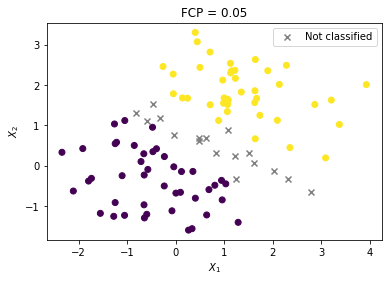

In [19]:
plt.scatter(x[selection,0], x[selection,1], c=ypred[selection])

#plot points that are not classified 
rejected = np.ones(n_samples, dtype=bool)
rejected[selection] = False
plt.scatter(x[rejected,0], x[rejected,1], label = 'Not classified', color = "grey", marker = 'x') 

plt.xlabel(r"$X_1$")
plt.ylabel(r"$X_2$")
plt.legend(loc = 'upper right')
plt.title("FCP = {:.2f}".format(fcp_bs))
plt.show()
    

Non parametric bootstrap

In [15]:
selection = bootstrap_procedure(level, n_classes, x, parameters_estimates, probability_matrix, 
                                                    n_bootstrap_samples= 100, parametric=False, covariance_type = 'full')
fcp_bs_np, _, fsel_bs_np = get_fcp(selection, y, ypred)

print("FCP", fcp_bs_np)
print("Selection frequency", fsel_bs_np)

FCP 0.0
Selection frequency 0.42
